In [1]:
# Import modules
using Distributions
using LinearAlgebra
using Plots

# Import seismic modules
using seismic.Grids
using seismic.Rays
using seismic.Inversion

┌ Info: Precompiling seismic [4c880bc8-450f-4926-bad2-3fe51599cecd]
└ @ Base loading.jl:1278


# Define grid

In [2]:
## Step 1: Define grid: 50×50 grid cells (dimensions: 10m × 10m)
nx = ny = 20
N=nx*ny
Δx = Δy = 10. / nx
# Grid array, column major
grid = makeGrid(nx,ny,Δx,Δy);

In [3]:
# Compute cell centers coordinates for convenience
xc = [ p.x for p in grid.centers ]; xcticks = sort(unique(xc))
yc = [ p.y for p in grid.centers ]; ycticks = sort(unique(yc))

## Step 2: Define source
src = Point(-400., ny*Δy/2)

## Step 3: Define a distribution of receivers
n_recs = 100
rx = rand(Uniform(minimum(grid.xticks.+2Δx),maximum(grid.xticks.-2Δx)),n_recs)
ry = rand(Uniform(minimum(grid.yticks.+2Δy),maximum(grid.yticks.-2Δy)),n_recs)
recs = Point{Float64}[]
for i in 1:n_recs
    push!(recs,Point(rx[i], ry[i]))
end

## Step 4: Construct design matrix (shape: floats x grid_boxes)
D = distanceMatrix(recs, src, grid);

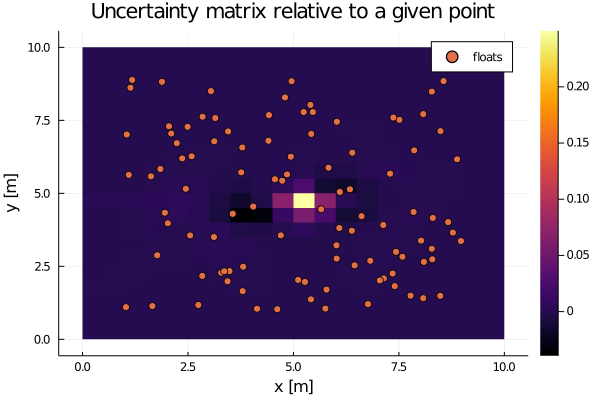

In [4]:
# The grid is 10m × 10m.
σxx = 1.      # variance of solution (variance of temperature/slowness field). Units: slowness [seconds / meter]
σnn = 1e-5    # variance of measurements. Units: seconds
σ_indp = 0.1  # independent TT noise
λ = 2.0       # spatial decorrelation scale. Units: meters

rxx = Rxx(grid, σxx, λ)
rnn = Rnn(Array(I(length(recs))),σnn,σ_indp)
ryy = Ryy(D,rxx,rnn)
P = uncertaintyMatrix(D,rxx,rnn);

heatmap(grid.xticks,grid.yticks,reshape(P[210,:],grid.nx,grid.ny))
title!("Uncertainty matrix relative to a given point"); xlabel!("x [m]"); ylabel!("y [m]")
scatter!(rx,ry,label="floats")

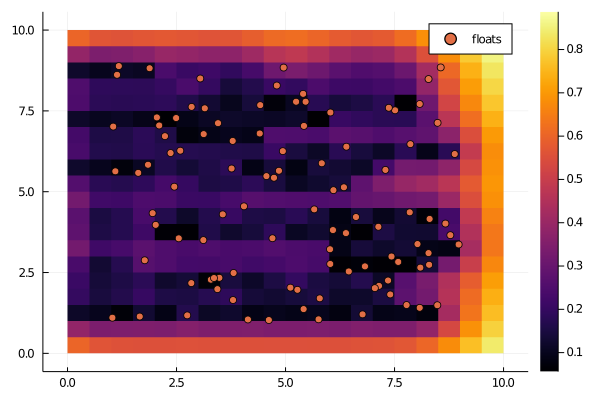

In [5]:
heatmap(grid.xticks,grid.yticks,reshape(diag(P),grid.nx,grid.ny))
scatter!(rx,ry,label="floats")

# Impose slowness perturbation field

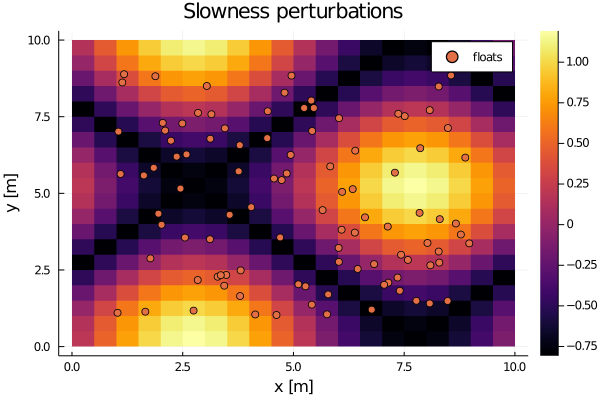

In [6]:
wλ=grid.nx * grid.Δx / 1;
f(x, y) = begin
    abs(sin.(2π/wλ*x) + cos.(2π/wλ*y))
end

Z = Array{Float64}(undef, length(grid.nodes))
for (i, node) in enumerate(grid.nodes)
    Z[i] = f(node.x, node.y)
end
Z = Z .- mean(Z)

heatmap(xcticks, ycticks, reshape(Z,grid.nx,grid.ny))
title!("Slowness perturbations"); xlabel!("x [m]"); ylabel!("y [m]")
scatter!(rx,ry,label="floats")

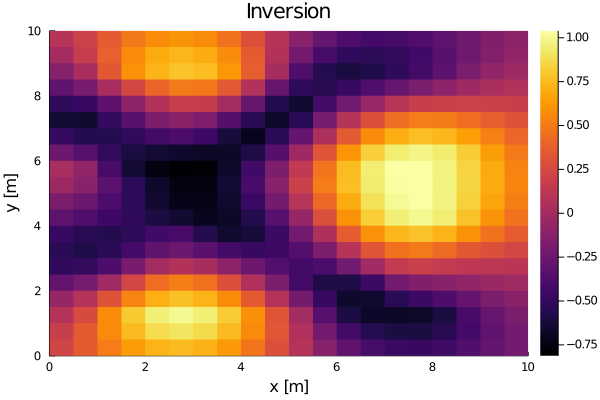

In [7]:
# Arrival times
τ = D * Z;

# solution
x̃ = computeInversion(D,rxx,rnn,τ);

heatmap(xcticks, ycticks, reshape(x̃,grid.nx,grid.ny))
title!("Inversion"); xlabel!("x [m]"); ylabel!("y [m]")